In [1]:
import logging
import os, sys
from pathlib import Path 
from typing import Dict, List 
import json
from omegaconf import OmegaConf,DictConfig
from hydra.core.hydra_config import HydraConfig
import pandas as pd 

from quvine.data.data_loader import load_graph, load_gwas_data
from quvine.data.prepare import PrepareGraphConfig, prepare_graph
from quvine.views.generator import ViewBuilder
from quvine.walks.base import BaseWalker
from quvine.corpus.builder import CorpusBuilder
from quvine.embedding.word2vec import corpus_to_embedding
from quvine.embedding.registry import EmbeddingStore
from quvine.analysis.compare import compare_embeddings
from quvine.analysis.analyze import *
from quvine.baselines import run_node2vec
from quvine.fusion.fuse import fuse_embeddings
from quvine.fusion.diagnostics import analyze_fusion
from quvine.evaluation.ranking import (
    seed_centroid_scores,
    max_seed_cosine_scores,
    evaluate_embeddings_ranking
    )   
#from quvine.evals.ranking import evaluate_ranking
# from utils.io import save_embeddings, save_metadata 
from quvine.utils.seed import set_global_seed
from quvine.utils.utilities import *
from joblib import Parallel, delayed


## Process data

In [2]:
def get_stats(G): 
    stats = {}
    stats['num_nodes'] = G.number_of_nodes()
    stats['num_edges'] = G.number_of_edges()
    stats['density'] = nx.density(G)
    stats['num_connected_components'] = nx.number_connected_components(G)
    largest_cc = max(nx.connected_components(G), key=len)
    stats['largest_cc_size'] = len(largest_cc)
    stats['average_clustering_coefficient'] = nx.average_clustering(G)
    degrees = [d for n, d in G.degree()]
    stats['average_degree'] = np.mean(degrees)
    stats['degree_assortativity_coefficient'] = nx.degree_assortativity_coefficient(G)
    betweenness = list(nx.betweenness_centrality(G).values())
    stats['average_clustering_coefficient'] = np.mean(betweenness)
    
    return stats

def draw_graph(G, pos=None, node_size=50, edge_color='black', node_color='blue', alpha=0.5):
    if pos is None:
        pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, node_size=node_size, edge_color=edge_color, node_color=node_color, alpha=alpha)
    plt.show()
    
def correct_names(df, col_name):
    new_nodes_v1 = []
    for x in df[col_name]:
        x_names = x.split('.')
        if len(x_names) == 2: 
            new_nodes_v1.append(x_names[0])
        else: 
            new_nodes_v1.append(x)
    return new_nodes_v1


## Generate a PPI-like random graph with modules

In [15]:
def generate_ppi_like_network(
    n_nodes=200,
    n_modules=6,
    intra_p=0.05,
    inter_p=0.005,
    seed=42
):
    
    rng = np.random.default_rng(seed)

    # Assign nodes to functional modules
    nodes = list(range(n_nodes))
    modules = rng.integers(0, n_modules, size=n_nodes)

    G = nx.Graph()
    G.add_nodes_from(nodes)

    # Preferential attachment within modules
    for m in range(n_modules):
        module_nodes = [i for i in nodes if modules[i] == m]
        if len(module_nodes) < 5:
            continue

        subG = nx.barabasi_albert_graph(
            len(module_nodes),
            m=3,
            seed=seed + m
        )

        mapping = dict(zip(subG.nodes(), module_nodes))
        subG = nx.relabel_nodes(subG, mapping)
        G.add_edges_from(subG.edges())

    # Add sparse inter-module interactions
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if modules[i] != modules[j]:
                if rng.random() < inter_p:
                    G.add_edge(i, j)

    # Remove isolated nodes (rare in real PPIs)
    G.remove_nodes_from(list(nx.isolates(G)))

    return G, modules


G, modules = generate_ppi_like_network()

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
print("Avg clustering:", nx.average_clustering(G))

Nodes: 200
Edges: 643
Avg clustering: 0.21857961809432397


In [22]:
G_mst = nx.maximum_spanning_tree(G)
stats_mst_df = pd.DataFrame.from_dict(get_stats(G),orient='index', columns=['value']).T
stats_mst_df

,num_nodes,num_edges,density,num_connected_components,largest_cc_size,average_clustering_coefficient,average_degree,degree_assortativity_coefficient
value,200.0,643.0,0.032312,1.0,200.0,0.012106,6.43,-0.21595


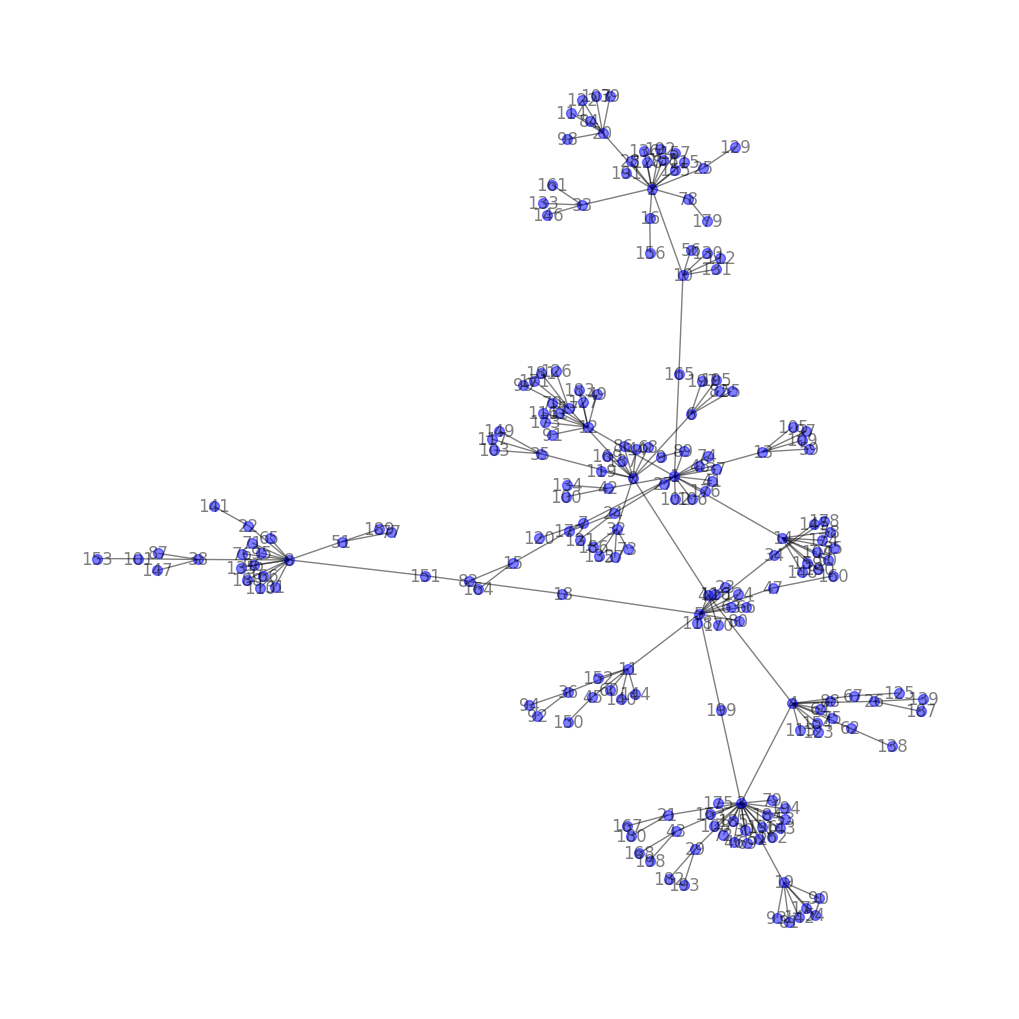

In [23]:
draw_graph(G_mst)

## QuVINE

In [30]:
from omegaconf import OmegaConf

cfg = OmegaConf.create({
    "data_path": "/dccstor/boseukb/CuNA/data/tcga_omics/OV/",

    "graph": {
        "name": "OvarianCancer",
        "path": "corrected_3y_survival_edges.csv",
    },

    # "disease": {
    #     "name": "schizophrenia",
    # },

    "runtime": {
        "name": "quvine",
        # originally: ${now:%Y-%m-%d_%H-%M-%S}
        # notebook-safe placeholder
        "run_name": "manual_run",
        "run_dir": "../outputs/",
        "n_jobs": 1,
        "chunk_size": 1, 
        "output_dir": "${runtime.run_dir}/${runtime.run_name}"
    },

    "experiment": {
        "iterations": 2,
        "base_seed": 42,
    },

    "seed": 42,
    "save_embeddings": True, 
    "compare_embeddings": True,
    
    "draw": {
        "graph": True,
        "verbose": False,
    },

    "preprocess": {
        "subsample": {
            "enabled": True,
            "max_nodes": 150,
            "radius": 3,
        },
        "sparsify": {
            "enabled": True,
            "retain_ratio": 0.9,
            "max_degree": 4,
            "scoring": 'common_neighbors'
        },
    },

    "verbose": True,
    "plots": True,

    "views": {
        "num_views": 5,
        "constrained": True,
        "max_degree": 4,
        "max_nodes": 30,
        "max_edges": 120,
        "degree_norm": True,
        "degree_alpha": 0.7
    },

    "walks": {
        "kinds": ["rwr", "ctqw", "dtqw"],
        "num_walks": 5,
        "walk_length": 6,
        "restart_prob": 0.3,
        "steps": 12,
        "time": 1.1,
        "coin": "grover",
        "max_iter": 1000,
    },

    # --------------------
    # shared hyperparameters
    # --------------------
    "dimension": 64,
    "window": 5,
    "min_count": 1,
    "workers": 8,

    "train": {
        "embedding_dim": 64,
        "window": 5,
        "sg": 1,
        "negative": 10,
        "workers": 8,
        "min_count": 1,
        "epochs": 100,
    },

    "baselines": {
        "node2vec": {
            "enabled": True,
            "dimensions": 64,
            "walk_length": 8,
            "num_walks": 10,
            "p": 1,
            "q": 0.5,
            "window": 5,
            "min_count": 1,
            "workers": 8,
            "seed": 42,
        },
    },

    "fusion": {
        "enabled": True,
        "method": "all",
        "k": 25,
    },

    "analysis": {
        "cca_components": 10,
        "knn_k": 5,
    },

    "evaluation": {
        "enabled": False,
        "k_values": [20, 40, 80],
        "n_repeats": 20,
        "deg_tol": 0.1,
        "centroid": False, 
        "max_seed": True
    },
})


In [31]:
def set_iteration_seed(cfg, it):
    seed = cfg.seed + it
    set_global_seed(seed)
    
def build_views(cfg, graph_data, root, rng):
        
    view_gen = ViewBuilder(cfg=cfg, rng=rng)
    return view_gen.build(graph_data, root)
    
def run_walks_for_root(cfg, graph_data, root, views, rng): 
    
    walker = BaseWalker(cfg=cfg, rng=rng)
    all_walks = {k: [] for k in cfg.walks.kinds}
    
    for view in views: 
        #induce subgraph 
        view_g = graph_data.subgraph(view)
        view_nodes = list(view_g.nodes())
        
        if len(view_nodes) < 2: 
            continue 
        if view_g.number_of_edges() == 0:
            continue 
        
        #run walker once per view 
        out = walker.run(graph_data, root, view_nodes)
        
        for walk_kind, walks in out.items(): 
            all_walks[walk_kind].extend(walks)
    
    return all_walks

def train_embeddings(cfg, graph_data, all_corpora):
    embeddings = {} 
    node_list = list(graph_data.nodes)
    
    
    for kind, corpus in all_corpora.items(): 
                
        Z = corpus_to_embedding(
                                corpus=corpus, 
                                nodes=node_list,
                                vector_size=cfg.train.embedding_dim, 
                                window=cfg.train.window,
                                sg=cfg.train.sg, 
                                negative=cfg.train.negative, 
                                min_count=cfg.min_count,
                                workers=cfg.train.workers, 
                                epochs=cfg.train.epochs
                                )
        
        embeddings[kind] = Z
    
    return embeddings

def chunkify(seq, chunk_size): 
    for i in range(0, len(seq, chunk_size)): 
        yield seq[i:i + chunk_size]
    
def process_root(graph_data, root, node2idx, it): 
        
        idx = node2idx[root]
        seed = (cfg.experiment.base_seed + 10000 * it + idx)
        rng = np.random.default_rng(seed)
        
        views = build_views(cfg, graph_data, root, rng) 
        walk_outputs = run_walks_for_root(cfg, graph_data, root, views, rng) 
        
        if not walk_outputs or all(len(walks) == 0 for walks in walk_outputs.values()):
            return root, {}   # or mark as invalid
        else:
            return root, walk_outputs

def process_root_chunk(graph_data, roots, node2idx, it):
    """
    Process a batch of roots inside a single worker process.
    Returns a list of (root, walk_outputs).
    """
    results = []

    for root in roots:
        root, walk_outputs = process_root(graph_data, root, node2idx, it)
        results.append((root, walk_outputs))

    return results     

def post_process_comparison(all_results): 
    comparison_rows = []

    for r in all_results:
        it = r["iteration"]
        for pair, metrics in r["comparison"].items():
            for name, value in metrics.items():
                comparison_rows.append({
                    "iteration": it,
                    "pair": pair,
                    "metric": name,
                    "value": value,
                })

    comparison_df = pd.DataFrame(comparison_rows)
    
    return comparison_df
        
def raw_diff(A, B, nameA="A", nameB="B"):
    import numpy as np
    print(nameA, nameB)
    print("  max|diff|:", float(np.max(np.abs(A - B))))
    print("  mean|diff|:", float(np.mean(np.abs(A - B))))
    print("  allclose:", bool(np.allclose(A, B, atol=1e-12, rtol=0)))

def save_embeddings(all_results):

    out_dir = cfg.runtime.output_dir
    emb_dir = os.path.join(out_dir, "embeddings")
    os.makedirs(emb_dir, exist_ok=True)


    for res in all_results:
        iter_num = res["iteration"]
        
        # Build dictionary for np.savez
        npz_payload = {}

        for emb_name, emb in res["embeddings"].items():
            if emb is None:
                continue
            npz_payload[emb_name] = emb.astype(np.float32, copy=False)

        # Always store node ordering for alignment downstream
        npz_payload["nodes"] = np.asarray(res["nodes"])

        ofname = os.path.join(
            emb_dir, f"embeddings_iter_{iter_num}.npz"
        )

        np.savez_compressed(ofname, **npz_payload)
        
        comparison_df = post_process_comparison(all_results=all_results)
        comp_ofname = "embedding_comparison_iter"+str(iter_num)+'.csv'
        comparison_path = os.path.join(emb_dir, comp_ofname)
        comparison_df.to_csv(comparison_path, index=False)
    

def run_single_iteration(cfg, it, graph_data, source=None, target=None):
    
    # setup 
    roots = list(graph_data.nodes)
    node2idx = {node: i for i, node in enumerate(sorted(roots))}
    
    corpus_builder = {kind: CorpusBuilder()
                    for kind in cfg.walks.kinds}
    
    # decide serial vs parallel 
    n_roots = len(roots)
    if n_roots < 2000 or cfg.runtime.n_jobs == 1: 
        chunks = [roots]
        n_jobs = 1 
    else: 
        chunk_size = cfg.runtime.chunk_size 
        chunks = list(chunkify(roots, chunk_size))
        n_jobs = cfg.runtime.n_jobs 
        
    parallel = Parallel(n_jobs=n_jobs, 
                        backend='loky', 
                        batch_size=1, 
                        prefer='processes'
                        )
    
    valid_roots = 0
    nodeset = set(graph_data.nodes)
    
    for chunk_results in parallel(
        delayed(process_root_chunk)(graph_data, chunk, node2idx, it)
        for chunk in chunks
        ):
        
        for root, walk_outputs in chunk_results: 
            if not walk_outputs or all(len(w)==0 for w in walk_outputs.values()):
                continue 
            valid_roots +=1 
            
            for walk_kind, walks in walk_outputs.items(): 
                if len(walks) == 0: 
                    continue 
                for w in walks:
                    for t in w:
                        assert t in nodeset, (
                            f"[{walk_kind}] invalid token {t} "
                            f"(root={root})"
                        )
                corpus_builder[walk_kind].add(root, walks)
                
    
    assert valid_roots > 0, "No valid roots with walks were found."
    
    all_corpora = {kind: builder.build() 
                for kind, builder in corpus_builder.items()}
    
    for kind, corpus in all_corpora.items():
        toks = {t for w in corpus for t in w}
        nodes = set(graph_data.nodes)
        assert toks <= nodes, f"{kind}: corpus contains non-node tokens!"
        
    # for k,c in all_corpora.items():
    #         print(k, corpus_hash(c))
    
    embeddings = train_embeddings(cfg, graph_data, all_corpora)
    
    store = EmbeddingStore()
    for name, Z in embeddings.items():
        store.add(name, Z)
            
    if cfg.baselines.node2vec.enabled:
        Z_n2v = run_node2vec(
                    graph=graph_data,
                    nodes=graph_data.nodes,
                    dimensions=cfg.baselines.node2vec.dimensions,
                    walk_length=cfg.baselines.node2vec.walk_length,
                    num_walks=cfg.baselines.node2vec.num_walks,
                    p=cfg.baselines.node2vec.p,
                    q=cfg.baselines.node2vec.q,
                    window=cfg.baselines.node2vec.window,
                    min_count=cfg.baselines.node2vec.min_count,
                    workers=cfg.baselines.node2vec.workers,
                    seed=cfg.baselines.node2vec.seed
                    )
        store.add("node2vec", Z_n2v)
    
    if cfg.compare_embeddings: 
        # compare embeddings 
        comparison_metrics = compare_embeddings(
                                        store,
                                        cca_components=cfg.analysis.cca_components,
                                        knn_k=cfg.analysis.knn_k,
                                        )
    else: 
        comparison_metrics = None
    
    
    if cfg.fusion.enabled:
        L = nx.normalized_laplacian_matrix(G=graph_data, 
                                    nodelist=graph_data.nodes).toarray().astype(np.float32)
        
        fused_list, fuse_metric = fuse_embeddings(
            store,
            method=cfg.fusion.method,
            k=cfg.fusion.k, 
            L=L
        )
        
        for i, Z_fused in enumerate(fused_list): 
            store.add(fuse_metric[i], Z_fused)
            
    if cfg.evaluation.enabled: 
        if source == None or target == None: 
            raise ValueError("source and target required!")
        
        seed_indices = [
            i for i, node in enumerate(graph_data.nodes)
            if node in source
        ]
        scores_by_method = {}
        for name, Z in store.items():
            if cfg.eval.centroid:
                scores_by_method[f"{name}_centroid"] = seed_centroid_scores(
                    Z, seed_indices
                )
            if cfg.eval.max_seed:
                scores_by_method[f"{name}_max"] = max_seed_cosine_scores(
                    Z, seed_indices
                )
        
        ranking_df = evaluate_embeddings_ranking(
            scores_by_method=scores_by_method,
            subgraph=graph_data,
            seeds=source,
            targets=target,
            nodes=graph_data.nodes,
            k_values=cfg.eval.k_values,
            n_repeats=cfg.eval.n_repeats,
            deg_tol=cfg.eval.deg_tol,
            iteration=it,
        )
        # standard metadata for analysis 
        
        return {
                "iteration": it,
                "ranking_df": ranking_df,
                "comparison": comparison_metrics
            }
    else:
        return {
            "iteration": it, 
            "embeddings": store, 
            "nodes": list(graph_data.nodes), 
            "comparison": comparison_metrics
        }


In [35]:
cfg_pg = PrepareGraphConfig(
    subsample_nodes=cfg.preprocess.subsample.enabled, 
    max_nodes=cfg.preprocess.subsample.max_nodes, 
    radius=cfg.preprocess.subsample.radius,
    sparsify_edges=cfg.preprocess.sparsify.enabled,
    retain_ratio=cfg.preprocess.sparsify.retain_ratio,
    max_degree=cfg.preprocess.sparsify.max_degree,
    scoring=cfg.preprocess.sparsify.scoring,
    verbose=cfg.verbose
)

graph_data = prepare_graph(cfg_pg,
                        graph=G, 
                        seed=cfg.seed
                        )
graph_data = nx.relabel_nodes(graph_data, lambda x: str(x))


--------------------------------------------------
After prepare_graph()
Nodes: 186
Edges: 278
Avg degree: 2.99
Max degree: 4
--------------------------------------------------


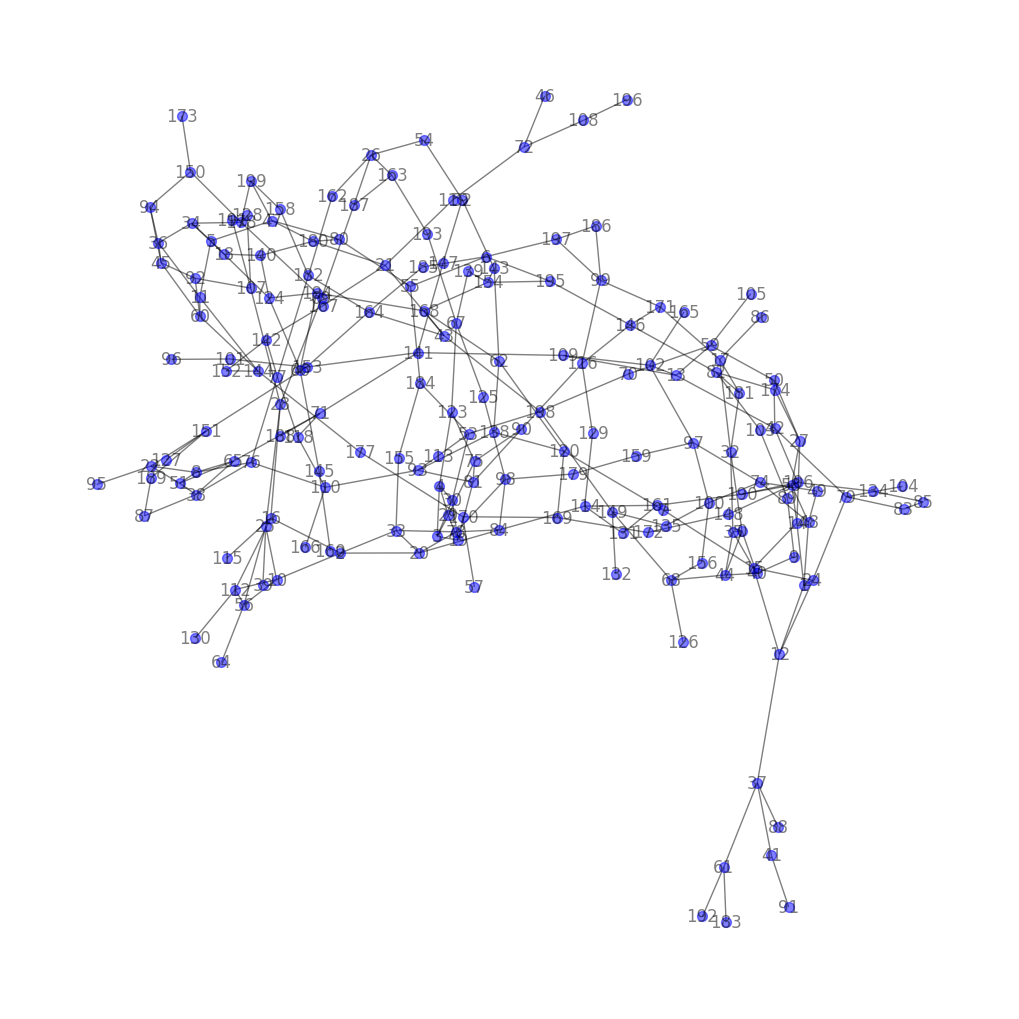

In [36]:
draw_graph(G=graph_data) 

In [37]:
n_iters = cfg.experiment.iterations
all_results = []
for it in range(n_iters):
    print(f"Iteration {it+1}/{n_iters}")
    set_iteration_seed(cfg, it)

    import traceback 
    try:
        res = run_single_iteration(cfg, it, graph_data)
    except Exception:
        traceback.print_exc(limit=50)
        raise 
    
    all_results.append(res)
    

Iteration 1/2


Computing transition probabilities:   0%|          | 0/186 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 2/2 [00:00<00:00, 345.21it/s]
/dccstor/boseukb/Q/NetMed/netbio/lib/python3.13/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/dccstor/boseukb/Q/NetMed/netbio/lib/python3.13/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/dccstor/boseukb/Q/NetMed/netbio/lib/python3.13/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/dccstor/boseukb/Q/NetMed/netbio/lib/python3.13/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", Co

Iteration 2/2


Computing transition probabilities:   0%|          | 0/186 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00, 361.80it/s]
/dccstor/boseukb/Q/NetMed/netbio/lib/python3.13/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/dccstor/boseukb/Q/NetMed/netbio/lib/python3.13/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/dccstor/boseukb/Q/NetMed/netbio/lib/python3.13/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/dccstor/boseukb/Q/NetMed/netbio/lib/python3.13/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", Co

## Save embeddings

In [38]:
save_embeddings(all_results=all_results)

In [39]:
path = os.path.join(cfg.runtime.output_dir, 'embeddings')
emb_dict = {}
for i in range(n_iters):
    emb_dict[i] = np.load(path+'/embeddings_iter_'+str(i)+'.npz')
emb_dict

{0: NpzFile '../outputs//manual_run/embeddings/embeddings_iter_0.npz' with keys: rwr, ctqw, dtqw, node2vec, svd...,
 1: NpzFile '../outputs//manual_run/embeddings/embeddings_iter_1.npz' with keys: rwr, ctqw, dtqw, node2vec, svd...}

### Now you can perform any downstream activities with these embeddings